In [1]:
from scipy import io
import GPy
import numpy as np
import matplotlib.pyplot as plt
import pylab as pb

In [2]:
def plot_2outputs(m,xlim,x_1,x_2):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1)

    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_2)),ax=ax2)

In [3]:
def build_XY(input_list,output_list=None):
    num_outputs = len(input_list)
    Y = np.vstack(output_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,Y,I

In [4]:
mat_file1 = io.loadmat('2014_Dataset1.mat')
t = mat_file1['t']
p1 = mat_file1['p1']
p2 = mat_file1['p2']

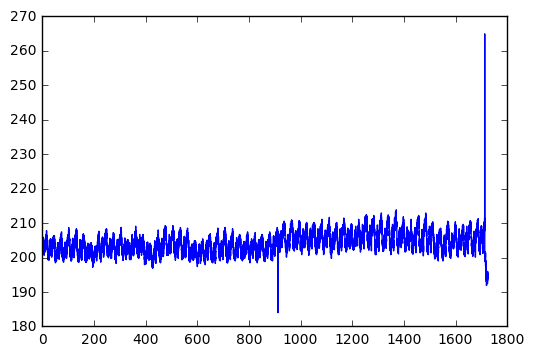

In [5]:
x = np.arange(0,len(p2)/10,0.1)[:,None]
plt.plot(x,p2)
plt.show()

# Anomaly Score

In [6]:
import pickle
f = open('d:/hyperparameter','rb')
gp = pickle.load(f)
f.close()

In [7]:
s = 0
l = 400
t = 10
it = range(s,s+l)
jt = range(s,s+l-t)
test = range(s+l-t,s+l)

In [8]:
def hyper_fix_score(kernel,s,l,t):
    it = range(s,s+l)
    jt = range(s,s+l-t)
    test = range(l-t,l)    
    mul2 = GPy.models.GPCoregionalizedRegression([x[it],x[jt]],[p1[it],p2[jt]],kernel = kernel)
    mul2['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul2['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    X,Y,I = build_XY([x[it],x[it]],[p1[it],p2[it]])
    mu,var = mul2.predict(X,Y_metadata=I,kern=mul2.kern,likelihood=mul2.likelihood)
    mu2 = mu[int(len(mu)/2):len(mu)]
    var2 = var[int(len(mu)/2):len(mu)]
    score = 0.5*np.log(var2[test]*np.pi*2) + (p2[test]-mu2[test])**2/(2*var2[test])
    a = np.average(score)
    return a

In [9]:
s = 8000
l = 400
t = 10
kern = gp.kern.copy()
score_list = []
for i in range(2000):
    a = hyper_fix_score(kern,s,l,t)
    score_list.append(a)
    s += 1

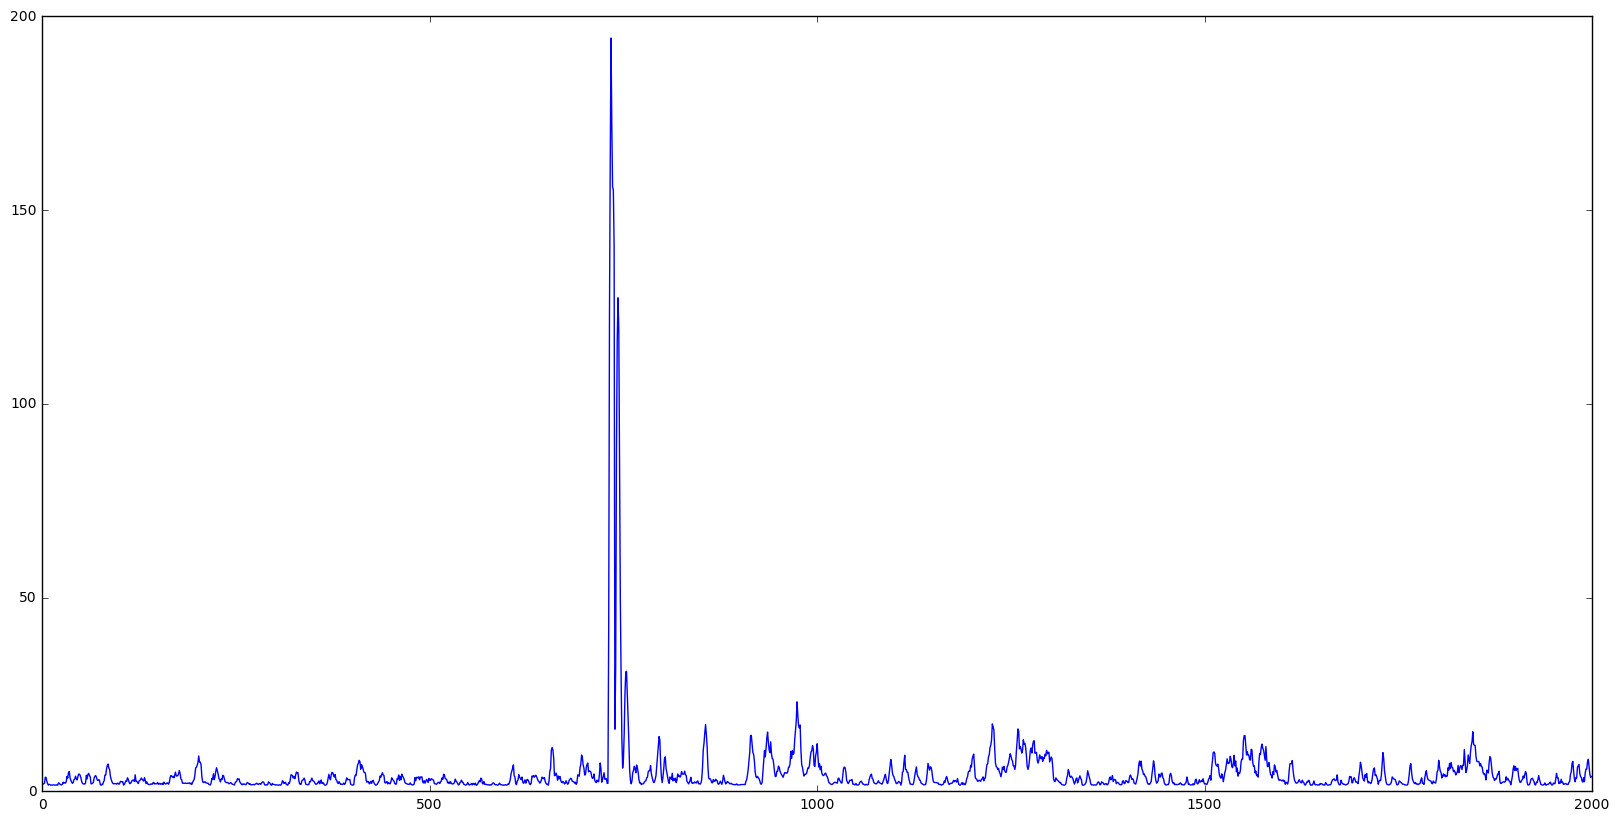

In [23]:
plt.figure(figsize=(20,10))
plt.plot(score_list)
plt.show()

## Threshold

In [24]:
def rbf(x1,x2,m):
    k = (np.absolute(x1,x2)**2)/(2*(2*m.kern.ICM0.rbf.lengthscale[0])**2)
    ke = np.exp(-k)
    return ke


In [30]:
s = 0
ez = GPy.models.GPCoregionalizedRegression([x[it],x[jt]],[p1[it],p2[jt]],kernel = kern)
ez['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
ez['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
X,Y,I = build_XY([x[it],x[it]],[p1[it],p2[it]])
mu,var = ez.predict(X,Y_metadata=I,kern=ez.kern,likelihood=ez.likelihood)
mu2 = mu[int(len(mu)/2):len(mu)]
var2 = var[int(len(mu)/2):len(mu)]

In [37]:
test_x = x[s+len(it)]
n = 0
for i in it:
    n += rbf(x[i],test_x,ez)
n

array([ 44.03783204])

In [38]:
alpha = 2*np.log(n)**(-0.5)
beta = (2*np.log(n))**(0.5) - (np.log(np.log(n)+np.log(2*np.pi)))/(2*(2*np.log(n))**0.5)
zp = beta-alpha*np.log(-np.log(0.95))
zp

array([ 5.49093423])

In [43]:
test_y = mu2[399]+zp*np.sqrt(var2[399])
score = 0.5*np.log(var2[399]*np.pi*2) + (test_y-mu2[399])**2/(2*var2[399])
score

array([ 17.12889432])

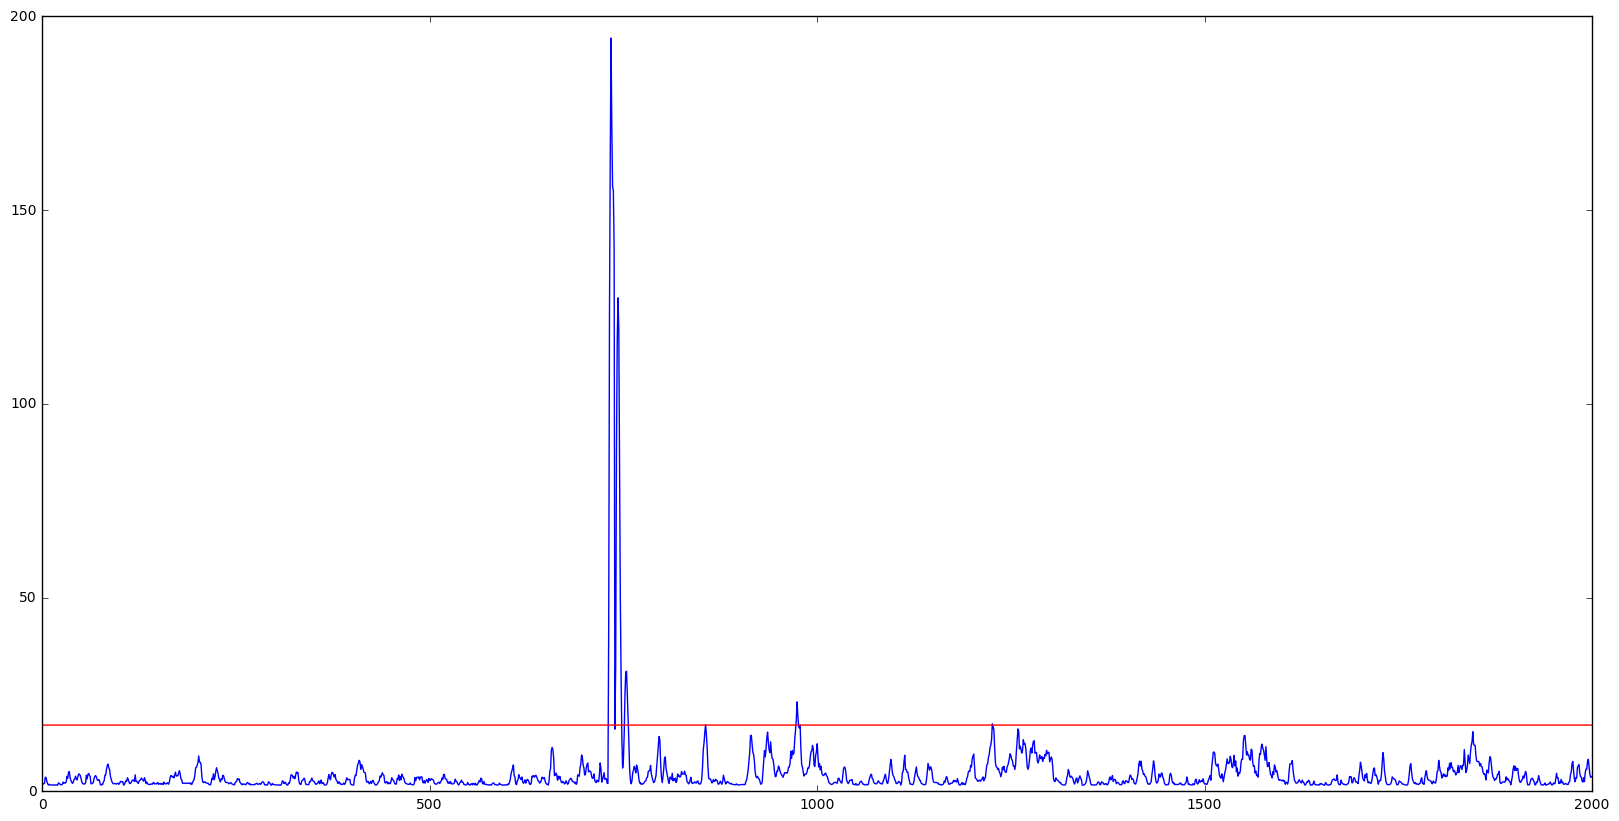

In [45]:
th = np.ones(len(score_list))*score
plt.figure(figsize=(20,10))
plt.plot(score_list)
plt.plot(th,color='red')
plt.show()

In [ ]:
np.a